In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import os
import time
import re
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from scipy.interpolate import griddata
from pearlsim.ml_utilities import *
from pearlsim.results_processing import read_core_flux
import pickle
from sklearn.neighbors import KNeighborsRegressor

In [35]:
ENERGY_BINS = np.array([1e-11, 5.8e-08, 1.4e-07, 2.8e-07, 6.25e-07, 9.72e-07, 1.15e-06,
                        1.855e-06, 4e-06, 9.877e-06, 1.5968e-05, 0.000148728, 0.00553,
                        0.009118, 0.111, 0.5, 0.821, 2.231, 10])
RADIUS_BINS = np.linspace(0, 120, 8+1)
HEIGHT_BINS = np.flip(np.linspace(60, 369.47, 20+1))
ENERGY_CENTERS = (ENERGY_BINS[1:] + ENERGY_BINS[:-1])/2


def read_det_file(file_name, normalize_and_label=False):
    reading=False
    energy_centers = ENERGY_CENTERS
    skip_names = ["E", "PHI", "Z", "R"]
    id_array = []
    x_array = []
    y_array = []
    z_array = []
    pebble_flux_matrix = []
    with open(file_name, 'r') as f:
        for line in f:
            line = line.replace("DET","")
            if "flux" in line or "peb" in line:
                if not any([x in line for x in skip_names]):
                    reading = True
                    data_array = []
                    unc_array = []
                    if "peb" in line:
                        header = line.split("_")
                        id_array += [int(header[1])]
                        x_array += [float(header[2])]
                        y_array += [float(header[3])]
                        z_array += [float(header[4])]
                        set_name = "peb"
                    else:
                        set_name = line.split()[0]
                        print(set_name)
            elif "]" in line and reading:
                reading = False
                if set_name == "fine_18group_flux":
                    core_flux = data_array
                elif set_name == "peb":
                    pebble_flux_matrix += [data_array]
            elif reading:
                data = float(line.split()[10])
                unc = float(line.split()[11])
                data_array += [data]
                unc_array += [unc]
    pebble_flux_matrix = np.array(pebble_flux_matrix)
    features = pd.DataFrame({"x": x_array, "y": y_array, "z": z_array })
    num_detectors = len(features)
    if normalize_and_label:
        core_flux_headers = []
        num_radius_bins = len(RADIUS_BINS)-1
        num_height_bins = len(HEIGHT_BINS)-1
        num_energy_bins = len(ENERGY_BINS)-1
        bin_e = 0
        bin_r = -1
        bin_z = 0
        for i in range(len(core_flux)):
            if bin_r == num_radius_bins-1:
                bin_r = 0
                if bin_z == num_height_bins-1:
                    bin_z = 0
                    bin_e += 1
                else:
                    bin_z += 1
            else:
                bin_r += 1
            # Calculate volume of a washer, noting that height bins are in descending
            # order while radius bins are increasing
            volume = np.pi*(RADIUS_BINS[bin_r+1]**2-RADIUS_BINS[bin_r]**2)*(HEIGHT_BINS[bin_z]-HEIGHT_BINS[bin_z+1])
            energy_width = ENERGY_BINS[bin_e+1]-ENERGY_BINS[bin_e]
            core_flux[i] = core_flux[i]/volume/energy_width
            core_flux_headers += [f"binR{bin_r+1}Z{bin_z+1}E{bin_e+1}"]
    else:
        core_flux_headers = ["bin" + str(n) for n in range(1, 1 + len(core_flux))]
    #features = pd.concat([features, pd.DataFrame([core_flux]*num_detectors,
    #                      columns=core_flux_headers)], axis=1)
    core_flux = pd.Series(data=core_flux, index=core_flux_headers)
    targets = pd.DataFrame(pebble_flux_matrix, columns=energy_centers)
    avg_uncertainty = np.mean(np.array(unc_array))
    return features, targets, core_flux,  avg_uncertainty

In [139]:
ENERGY_BINS = np.array([1e-11, 5.8e-08, 1.4e-07, 2.8e-07, 6.25e-07, 9.72e-07, 1.15e-06,
                        1.855e-06, 4e-06, 9.877e-06, 1.5968e-05, 0.000148728, 0.00553,
                        0.009118, 0.111, 0.5, 0.821, 2.231, 10])
RADIUS_BINS = np.linspace(0, 120, 8+1)
HEIGHT_BINS = np.flip(np.linspace(60, 369.47, 20+1))
ENERGY_CENTERS = (ENERGY_BINS[1:] + ENERGY_BINS[:-1])/2


def read_det_file(file_name, map_name="fine_18group_flux"):
    reading=False
    energy_centers = ENERGY_CENTERS
    skip_names = ["E", "PHI", "Z", "R"]
    id_array = []
    x_array = []
    y_array = []
    z_array = []
    pebble_flux_matrix = []
    core_flux_headers = []
    flattened_flux = []
    core_flux = np.zeros( (len(RADIUS_BINS)-1, len(HEIGHT_BINS)-1, len(ENERGY_BINS)-1 ) )
    with open(file_name, 'r') as f:
        for line in f:
            line = line.replace("DET","")
            if "flux" in line or "peb" in line:
                if not any([x in line for x in skip_names]):
                    reading = True
                    data_array = []
                    unc_array = []
                    if "peb" in line:
                        header = line.split("_")
                        id_array += [int(header[1])]
                        x_array += [float(header[2])]
                        y_array += [float(header[3])]
                        z_array += [float(header[4])]
                        set_name = "peb"
                    else:
                        set_name = line.split()[0]
                        print(set_name)
            elif "]" in line and reading:
                reading = False
                if set_name == "peb":
                    pebble_flux_matrix += [data_array]
            elif reading:
                line = line.split()
                if set_name == "peb":
                    data = float(line[10])
                    unc = float(line[11])
                    data_array += [data]
                    unc_array += [unc]
                elif set_name == map_name:
                    bin_e = int(line[1])-1
                    bin_r = int(line[9])-1
                    bin_z = int(line[7])-1
                    data = float(line[10])
                    volume = np.pi*(RADIUS_BINS[bin_r+1]**2-RADIUS_BINS[bin_r]**2)*(HEIGHT_BINS[bin_z]-HEIGHT_BINS[bin_z+1])
                    energy_width = ENERGY_BINS[bin_e+1]-ENERGY_BINS[bin_e]
                    core_flux[bin_r, bin_z, bin_e] = data/volume/energy_width
                    flattened_flux += [data/volume/energy_width]
                    core_flux_headers += [f"binR{bin_r+1}Z{bin_z+1}E{bin_e+1}"]

    pebble_flux_matrix = np.array(pebble_flux_matrix)
    features = pd.DataFrame({"x": x_array, "y": y_array, "z": z_array })
    num_detectors = len(features)
    core_flux_series = pd.Series(data=flattened_flux, index=core_flux_headers)
    targets = pd.DataFrame(pebble_flux_matrix, columns=energy_centers)
    avg_uncertainty = np.mean(np.array(unc_array))
    return features, targets, core_flux, core_flux_series, avg_uncertainty, id_array

In [140]:
training_steps = [1, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400]
directory = "gFHR_equilibrium/current_dataset/"
num_neighbors = 324
all_features = pd.DataFrame([])
all_targets = pd.DataFrame([])
last_current_grid = []
i = 1
# Load the Serpent Detector file, a matlab format file that has pebble surface flux
# and overall core flux. 
det_name = f"gFHR_equilibrium_training_{i}.serpent_det0.m"

# Load the auxiliary feature file, which are additionally features I included from
# the model that tell you more about the respective pebble for each surface
aux_name = f"current_auxiliary_features{i}.csv"
features, targets, core_flux, core_flux_series, avg_uncertainty, pebble_ids = read_det_file(directory+det_name)


zone_3group_flux
fine_18group_flux


In [155]:
def interpolate_core_flux(position_df, core_flux_map, num_neighbors, points_per_cm = 1,
                         min_r = 0, max_r = 120, r_bins = 8,
                         min_z = 60, max_z = 369.47, z_bins = 20,
                         plot_group=None):
    num_r_points = int((max_r-min_r)*points_per_cm)
    num_z_points = int((max_z-min_z)*points_per_cm)
    r_array = np.linspace(0+1e-6,120-1e-6, num_r_points)
    z_array = np.linspace(min_z+1e-6,max_z-1e-6,num_z_points)
    r_bin_bounds = np.linspace(min_r,max_r,r_bins+1)
    z_bin_bounds = np.linspace(min_z,max_z,z_bins+1)
    R, Z = np.meshgrid(r_array,z_array)
    knn_model = KNeighborsRegressor(n_neighbors=num_neighbors)
    predicted_df = pd.DataFrame()
    for energy_bin in range(1,18+1):
        bin_label = f"E{energy_bin}"
        flux_matrix = core_flux_map[:,:,energy_bin-1]
        #print(np.shape(flux_matrix))


        point_fluxes = np.zeros([num_r_points,num_z_points])

        for r_ind in range(len(r_array)):
            for z_ind in range(len(z_array)):
                r = r_array[r_ind]
                z = z_array[z_ind]
                r_bin = np.searchsorted(r_bin_bounds, r)-1
                z_bin = z_bins - np.searchsorted(z_bin_bounds, z)
                point_fluxes[r_ind,z_ind] = flux_matrix[r_bin,z_bin]
                #print(z_bin_bounds)
                #print(f"{r}, {z} -> {r_bin} rbin {z_bin} zbin")
                #print(flux_matrix[r_bin,z_bin])
        training_data = pd.DataFrame({"radius":R.T.flatten(), "height":Z.T.flatten()})
        target_data = pd.DataFrame({"flux":point_fluxes.flatten()})
        knn_model.fit(training_data, target_data)
        predicted = knn_model.predict(position_df)
        if type(plot_group) == int:
            if energy_bin == plot_group:
                plt.figure()
                plt.imshow(np.rot90(point_fluxes,1), extent=(0,120,60,370), aspect='auto')
                plt.colorbar()
                plt.title(f"Flux Distribution by Zone")
                plt.xlabel("Radial Position (cm)")
                plt.ylabel("Height (cm)")
                plt.show()
                
                predicted_grid = knn_model.predict(training_data).reshape(num_r_points,num_z_points)
                plt.figure()
                plt.imshow(np.rot90(predicted_grid,1),  extent=(0,120,60,370), aspect='auto')
                plt.colorbar()
                plt.title(f"KNN Resampled Flux on Finer Grid")
                plt.xlabel("Radial Position (cm)")
                plt.ylabel("Height (cm)")
                plt.show()
                
                interpolated_values = griddata((position_df['radius'],position_df['height']), predicted, (R, Z), rescale=True)
                plt.figure()
                plt.imshow(interpolated_values,origin='lower',  extent=(0,120,60,370), aspect='auto')
                plt.colorbar()
                plt.title(f"KNN Interpolated Flux at points")
                plt.xlabel("Radial Position (cm)")
                plt.ylabel("Height (cm)")
                plt.show()

        predicted_df[f"{bin_label}_flux_interpolated"] = pd.Series(predicted[:,0])
        #for i in range(len(position_df)):
        #    r = position_df.iloc[i]['radius']
        #    z = position_df.iloc[i]['height']
        #    r_bin = np.searchsorted(r_bin_bounds, r)
        #    z_bin = z_bins+1 - np.searchsorted(z_bin_bounds, z)
        #    print(f"{r}, {z} -> {r_bin} rbin {z_bin} zbin")
        #    print(flux_matrix[r_bin-1,z_bin-1])
        #    print(predicted[i])
    return predicted_df

zone_3group_flux
fine_18group_flux


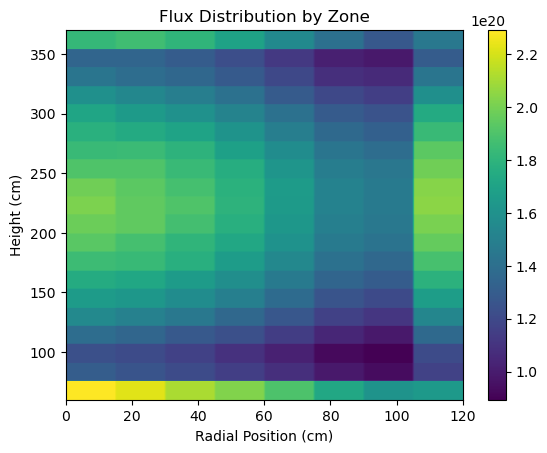

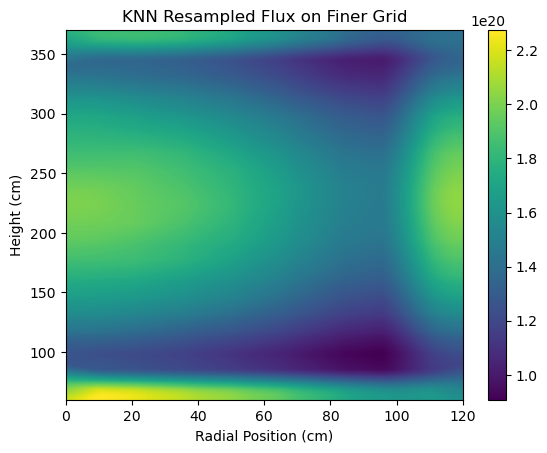

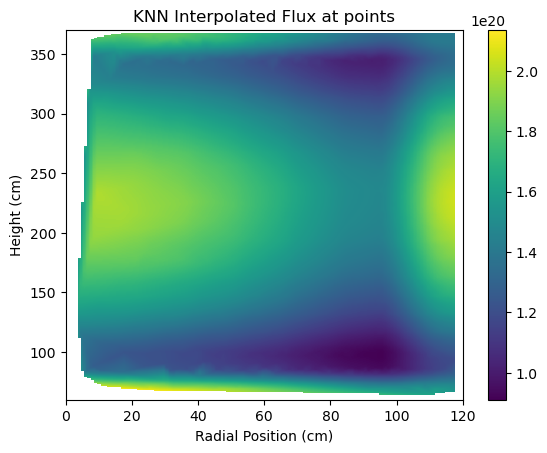

File gFHR_equilibrium_training_1.serpent_det0.m has an average 12.12% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


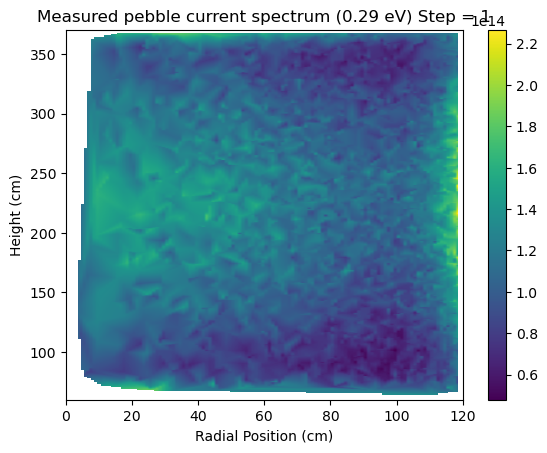

zone_3group_flux
fine_18group_flux


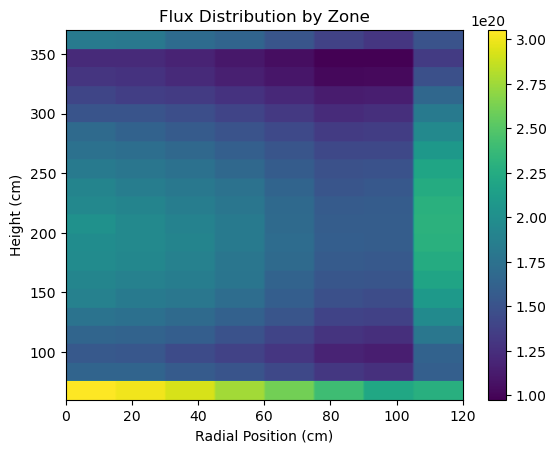

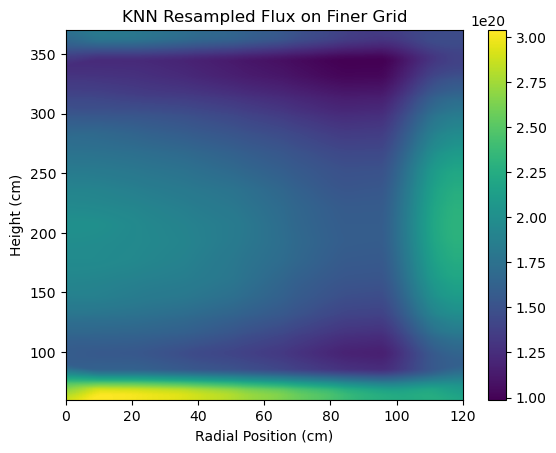

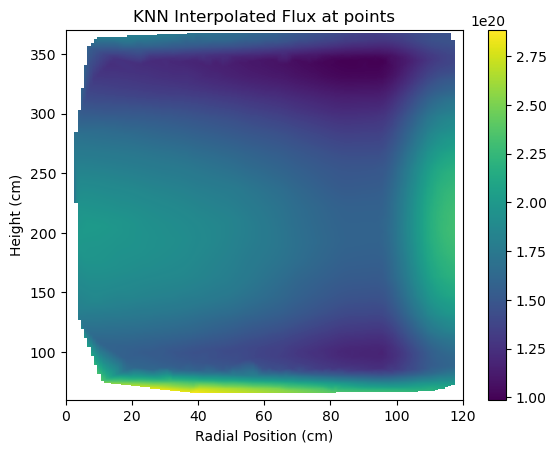

File gFHR_equilibrium_training_25.serpent_det0.m has an average 8.77% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


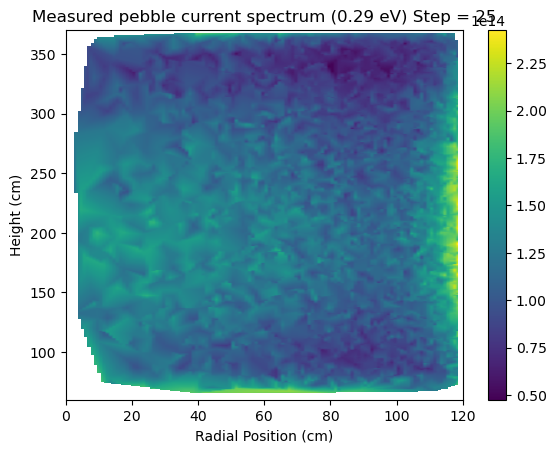

zone_3group_flux
fine_18group_flux


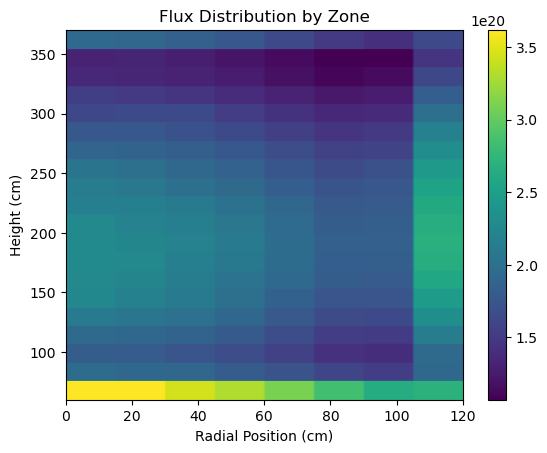

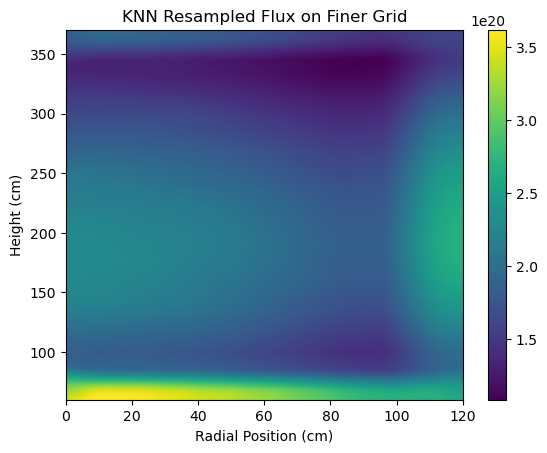

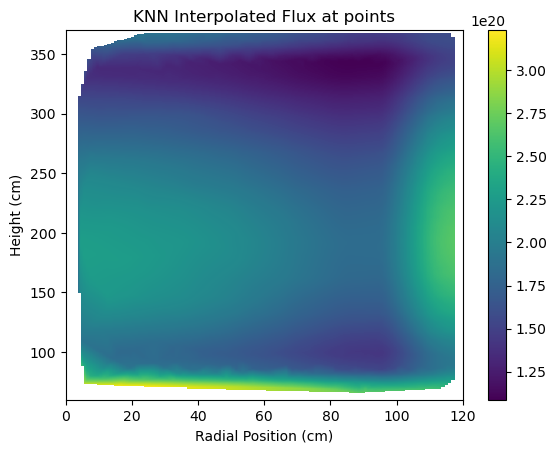

File gFHR_equilibrium_training_50.serpent_det0.m has an average 8.64% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


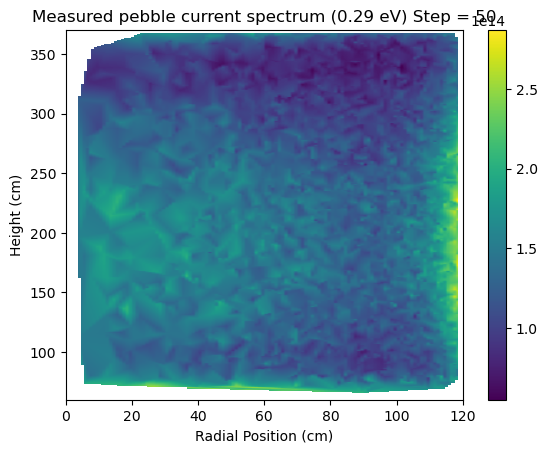

zone_3group_flux
fine_18group_flux


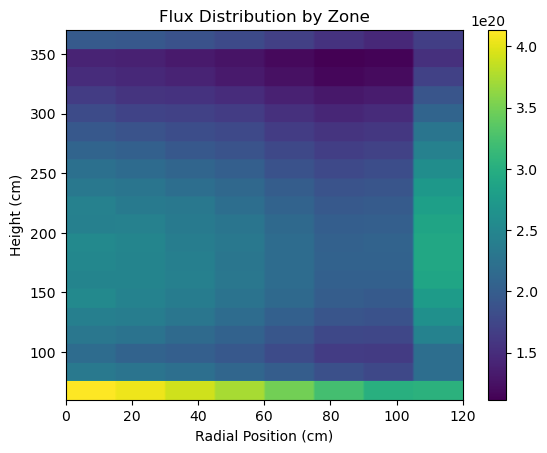

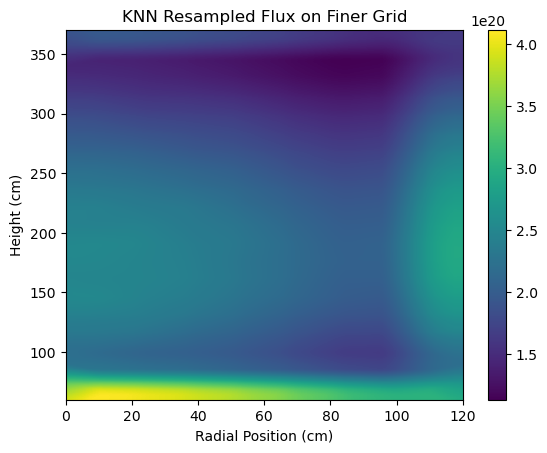

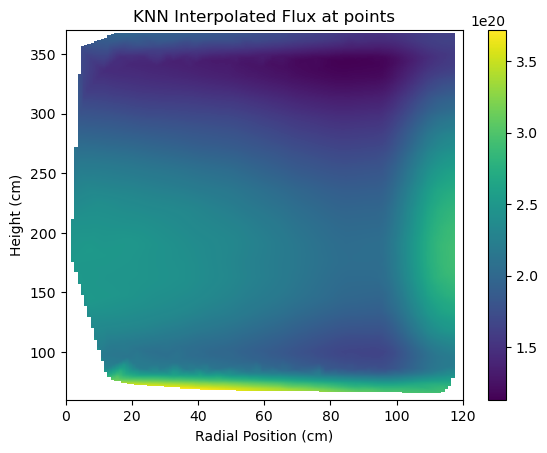

File gFHR_equilibrium_training_75.serpent_det0.m has an average 9.11% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


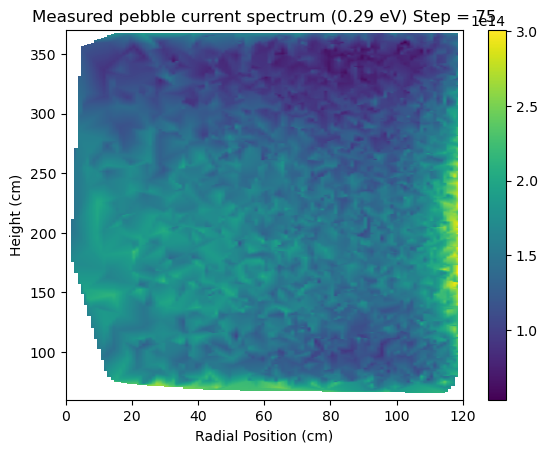

zone_3group_flux
fine_18group_flux


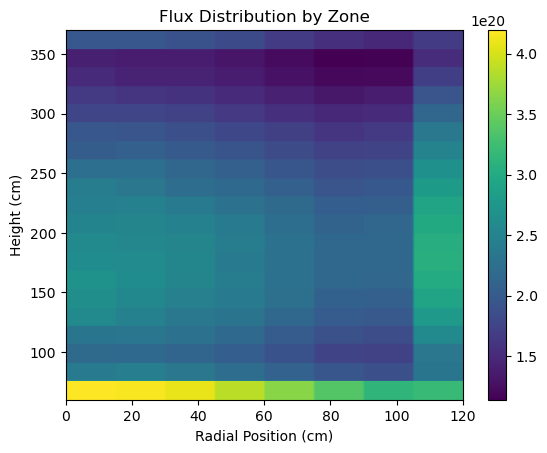

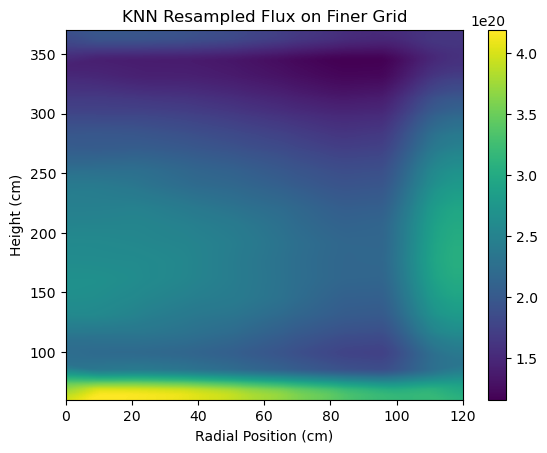

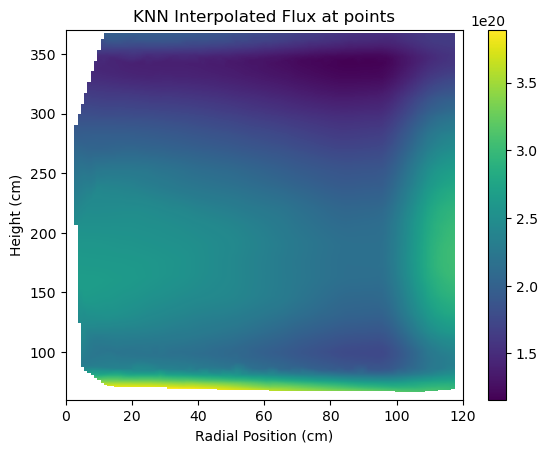

File gFHR_equilibrium_training_100.serpent_det0.m has an average 9.89% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


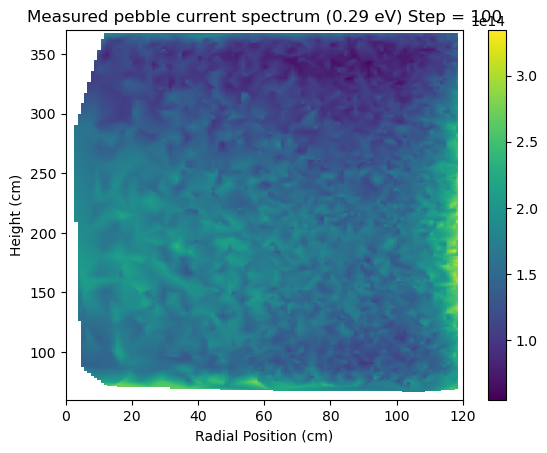

zone_3group_flux
fine_18group_flux


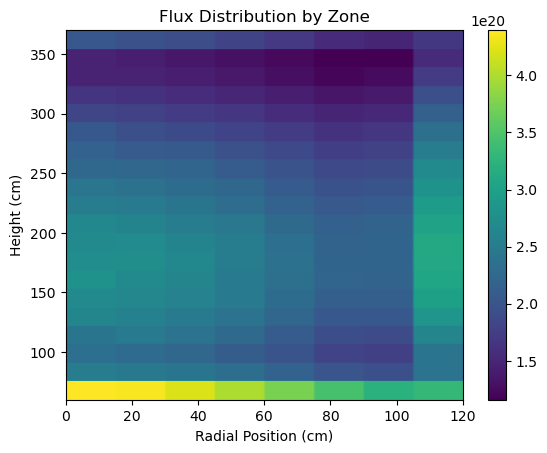

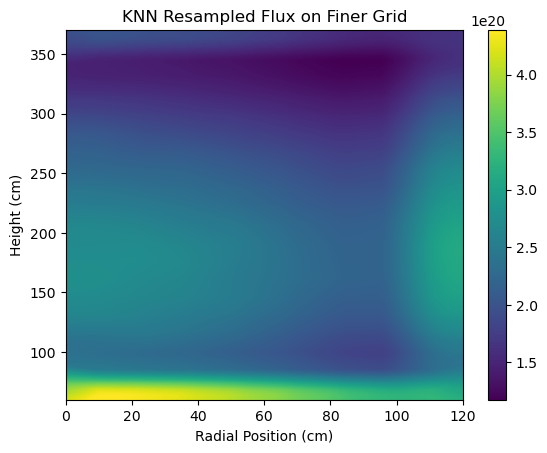

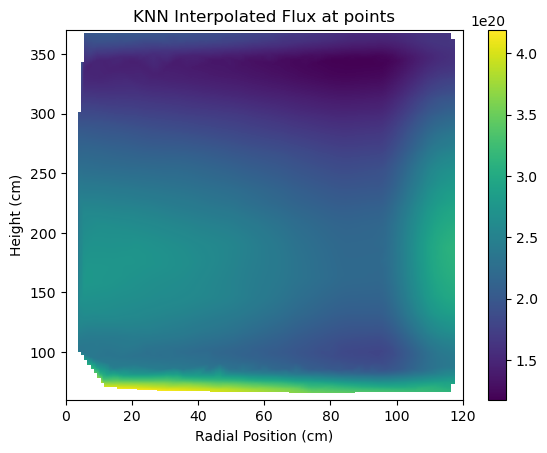

File gFHR_equilibrium_training_125.serpent_det0.m has an average 7.96% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


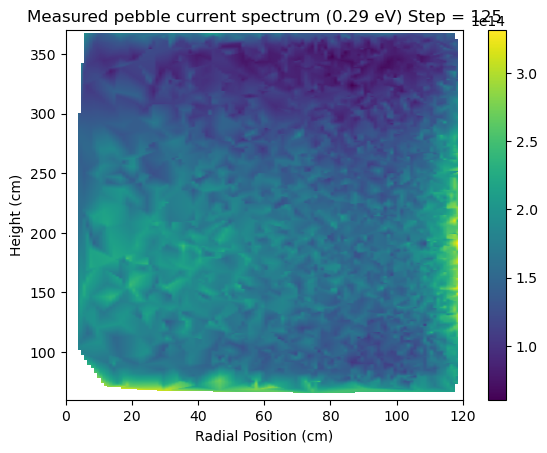

zone_3group_flux
fine_18group_flux


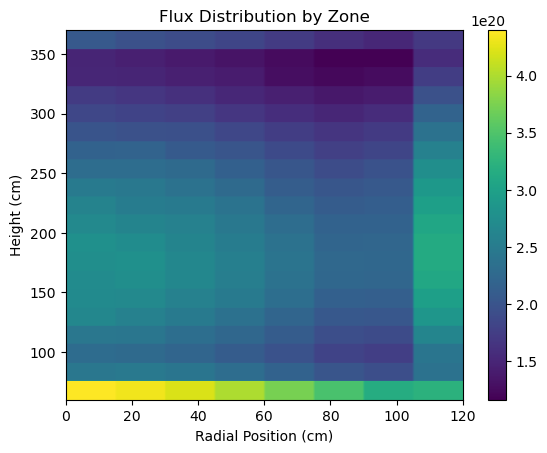

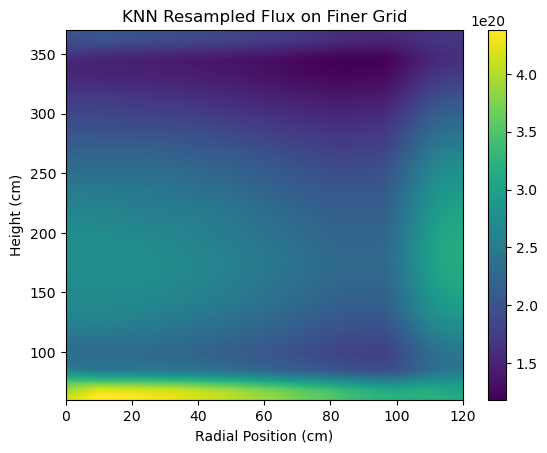

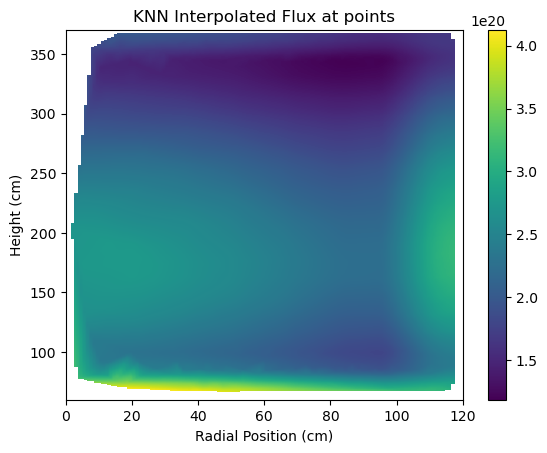

File gFHR_equilibrium_training_150.serpent_det0.m has an average 9.11% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


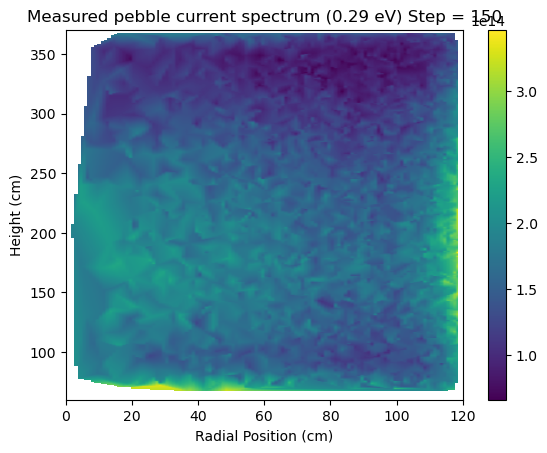

zone_3group_flux
fine_18group_flux


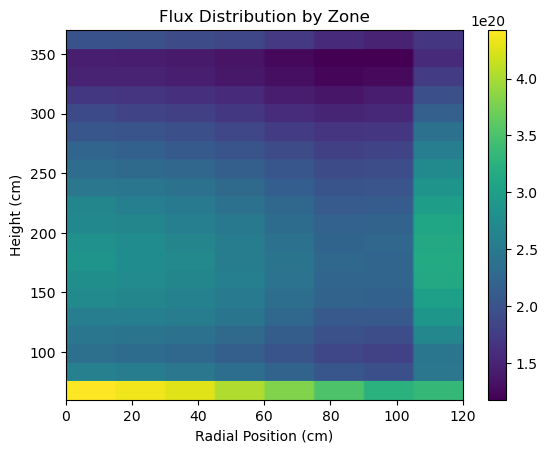

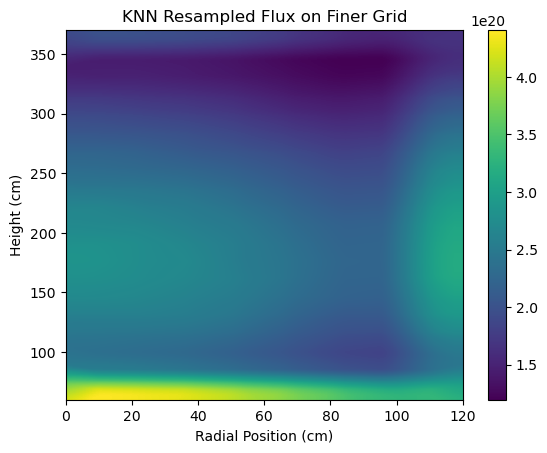

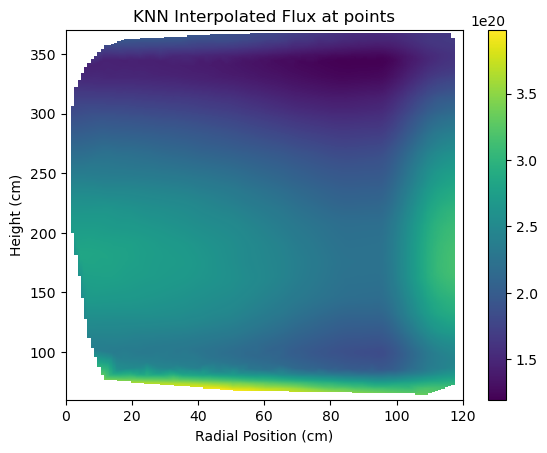

File gFHR_equilibrium_training_175.serpent_det0.m has an average 8.47% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


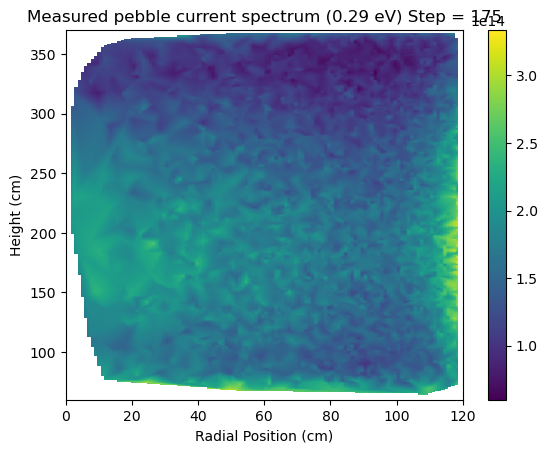

zone_3group_flux
fine_18group_flux


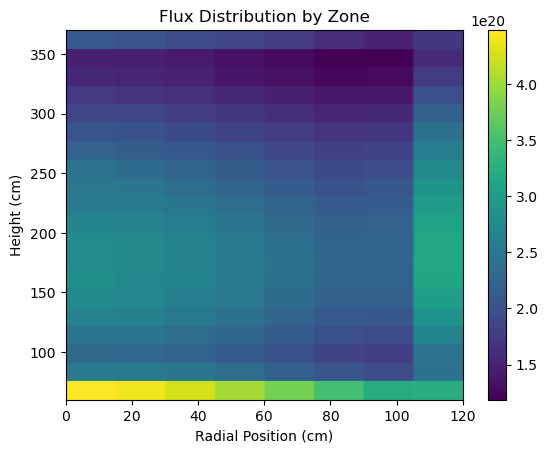

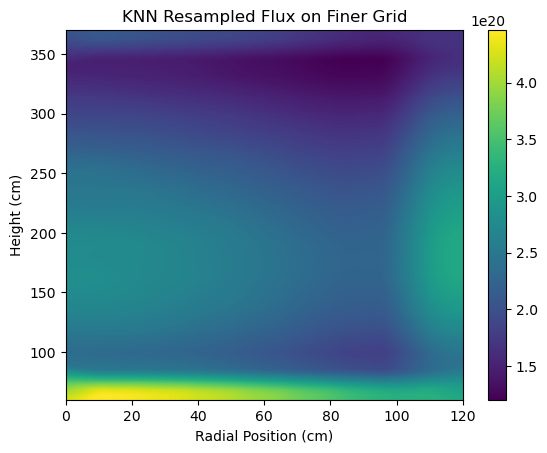

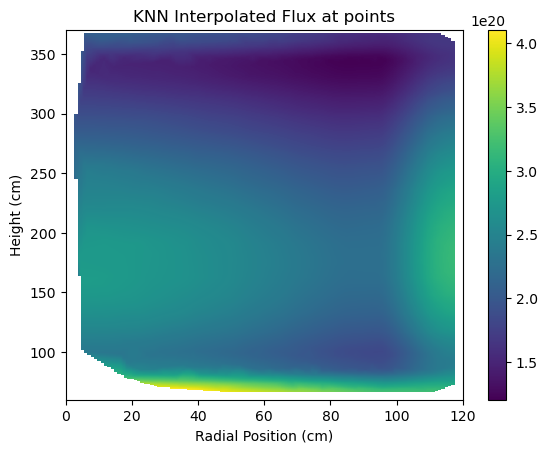

File gFHR_equilibrium_training_200.serpent_det0.m has an average 7.69% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


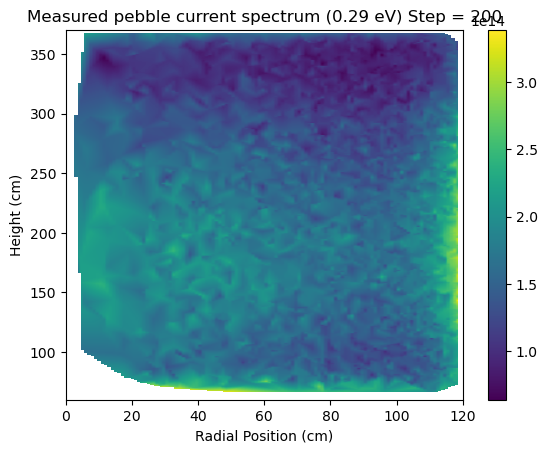

zone_3group_flux
fine_18group_flux


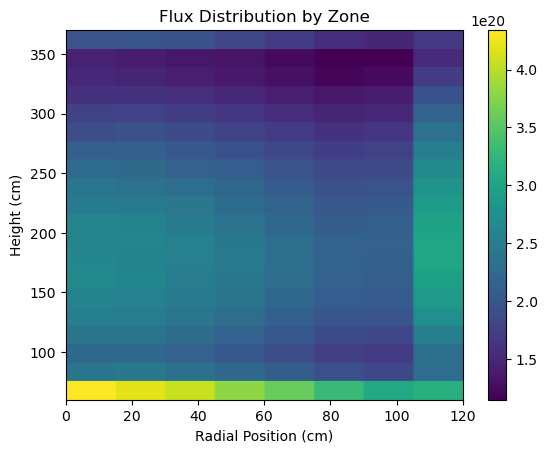

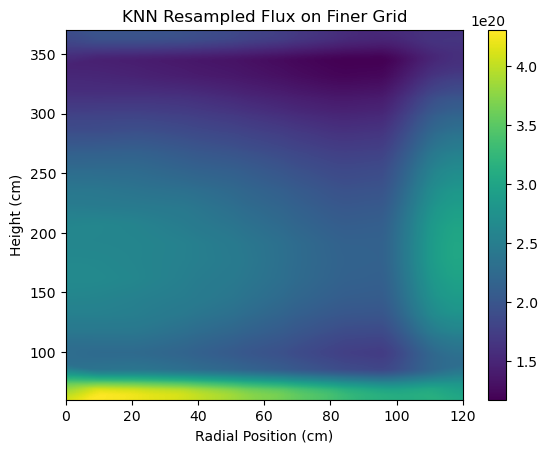

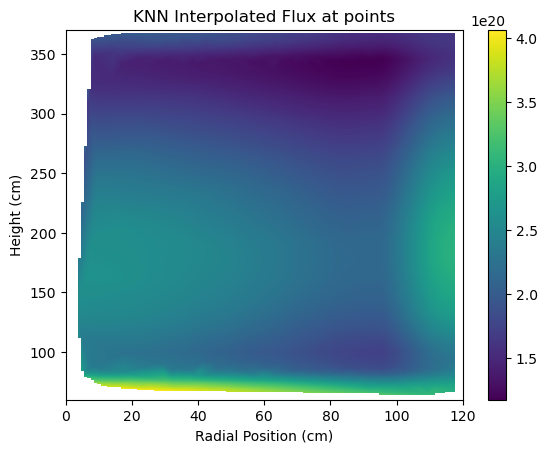

File gFHR_equilibrium_training_250.serpent_det0.m has an average 14.89% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


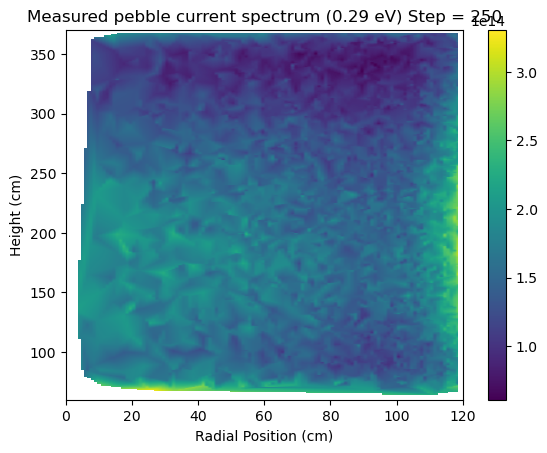

zone_3group_flux
fine_18group_flux


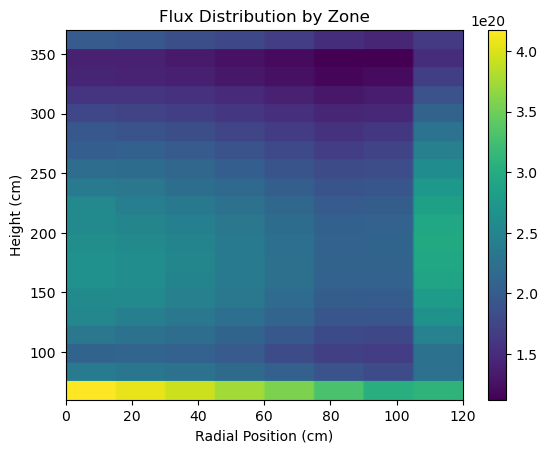

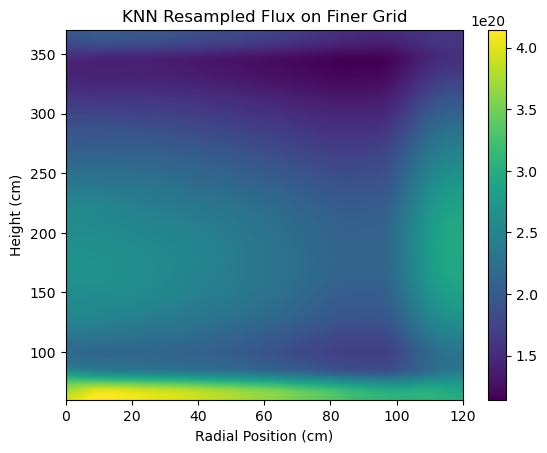

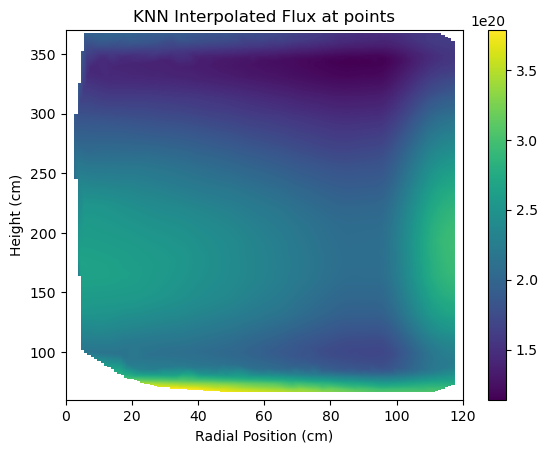

File gFHR_equilibrium_training_300.serpent_det0.m has an average 7.55% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


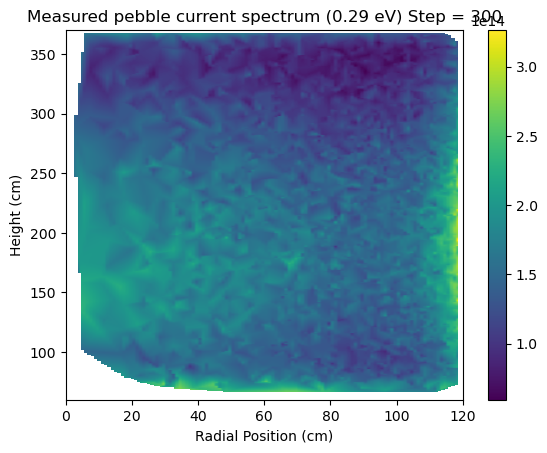

zone_3group_flux
fine_18group_flux


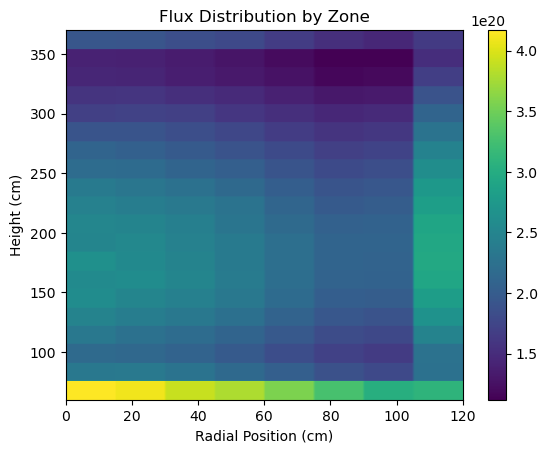

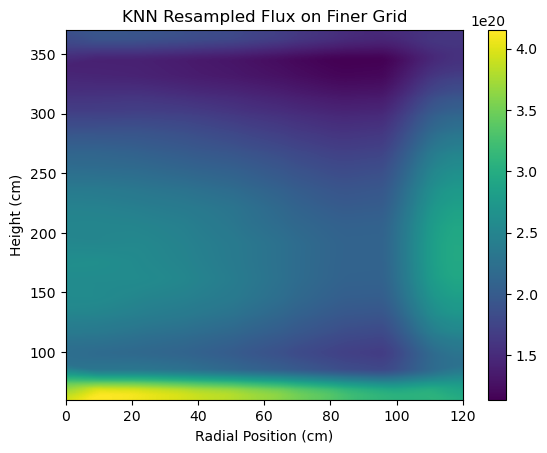

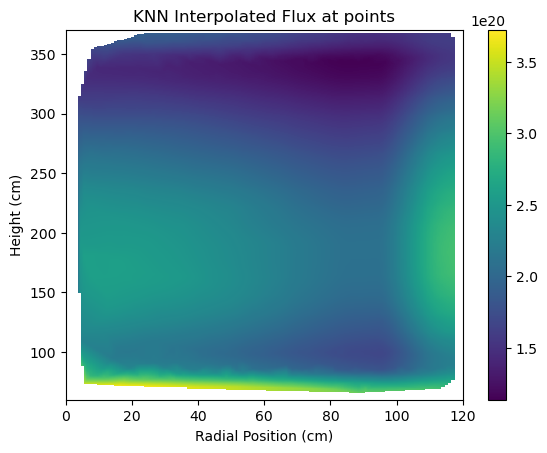

File gFHR_equilibrium_training_350.serpent_det0.m has an average 8.4% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


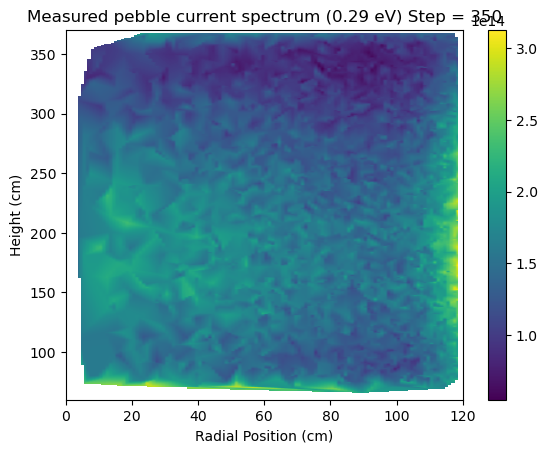

zone_3group_flux
fine_18group_flux


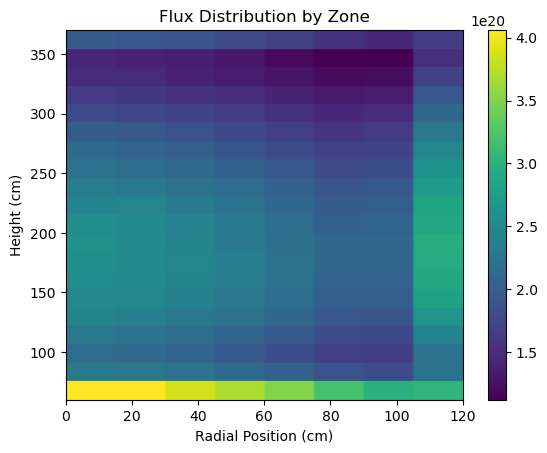

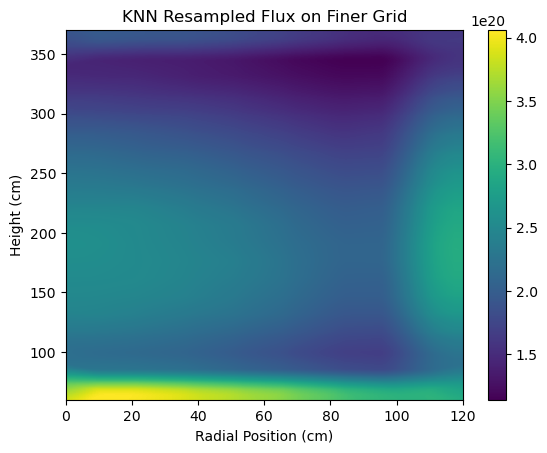

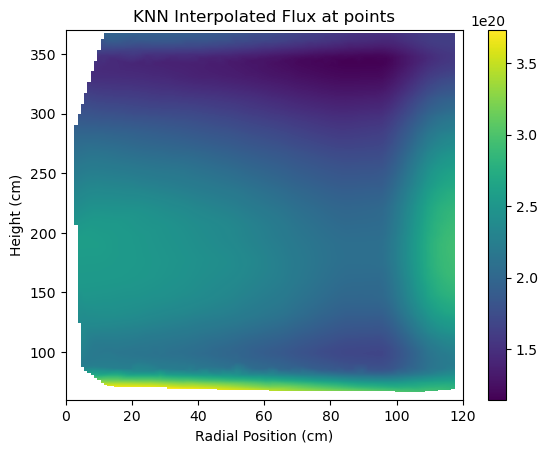

File gFHR_equilibrium_training_400.serpent_det0.m has an average 10.2% uncertainty.
[[  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 ...
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]
 [  0   1   2 ... 117 118 119]]
(310, 120)


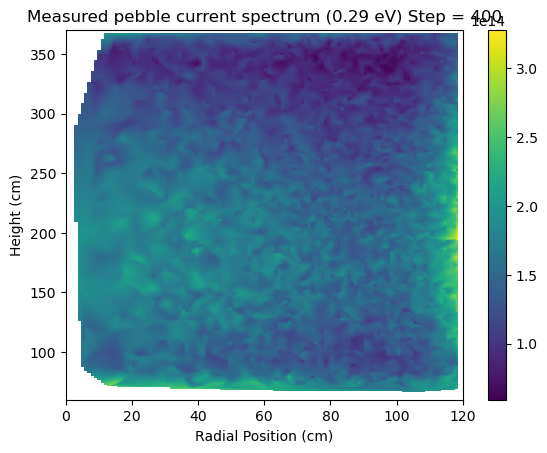

In [157]:
training_steps = [1, 25, 50, 75, 100, 125, 150, 175, 200, 250, 300, 350, 400]
directory = "gFHR_equilibrium/current_dataset/"
num_neighbors = 9*9*4
all_features = pd.DataFrame([])
all_targets = pd.DataFrame([])
last_current_grid = []
for i in training_steps:
    # Load the Serpent Detector file, a matlab format file that has pebble surface flux
    # and overall core flux. 
    det_name = f"gFHR_equilibrium_training_{i}.serpent_det0.m"
    
    # Load the auxiliary feature file, which are additionally features I included from
    # the model that tell you more about the respective pebble for each surface
    aux_name = f"current_auxiliary_features{i}.csv"
    features, targets, core_flux, core_flux_series, avg_uncertainty, pebble_ids = read_det_file(directory+det_name)
    #features = pd.concat([features, 
    #    pd.DataFrame(np.tile(core_flux_series.values, (len(features),1)), columns=list(core_flux_series.axes))], axis=1)
    
    if len(all_targets) > 0:
        assert last_current_grid.equals(targets.columns)
    
    last_current_grid = targets.columns
    energy_group = 1
    rename_headers = {}
    for energy in last_current_grid:
        rename_headers[energy] = f"current_E{energy_group}"
        energy_group += 1
    targets = targets.rename(columns=rename_headers)


    aux_features = pd.read_csv(directory+aux_name, index_col=0)
    
    # Read the pebble power file and grab the corresponding power values
    pow_name = f"pebble_positions_{i}.csv_pow0.m"
    pow_data = pd.read_csv(directory+pow_name, delimiter='\s+', 
                           names=['x','y','z','rad','universe','power','unc'])
    targets['power'] = pow_data['power'].iloc[pebble_ids].reset_index().drop(columns='index')
    features = aux_features.join(features)
    
    # Convert coordinates to 2D cylindrical, since the flux map is symmetrical
    features['radius'] = round(np.sqrt(features['x']**2+features['y']**2),1)
    features['height'] = round(features['z'],1)
    features = features.drop(columns=['x','y','z'])
    
    interpolated_flux = interpolate_core_flux(features[['radius','height']], core_flux, num_neighbors, plot_group=1)
    features = features.join(interpolated_flux)
    features['step'] = i
    
    print(f"File {det_name} has an average {round(avg_uncertainty*100,2)}% uncertainty.")
    all_features = pd.concat([all_features, features])
    all_targets = pd.concat([all_targets, targets])
    
    R = np.arange(0, 120, 1)
    Z = np.arange(60, 370, 1)
    X, Y = np.meshgrid(R, Z)
    print(X)
    print(np.shape(X))
    r = features['radius'].to_numpy()
    h = features['height'].to_numpy()
    parameter = "current_E1"
    param_interpolated = griddata((r,h), targets[parameter], (X, Y), rescale=True)
    plt.imshow(param_interpolated, origin='lower', extent=(0,120,60,370), aspect='auto')#, vmin=5E13, vmax=1E15)
    plt.colorbar()
    plt.title(f"Measured pebble current spectrum (0.29 eV) Step = {i}")
    plt.xlabel("Radial Position (cm)")
    plt.ylabel("Height (cm)")
    plt.show()

## For clarity, re-order the radius and height columns to be first and save
#headers = all_features.columns.to_list()
#headers.remove("radius")
#headers.remove("height")
all_features = all_features.reset_index(drop=True)
all_targets = all_targets.reset_index(drop=True)

In [158]:
all_features = all_features.reset_index(drop=True)
all_targets = all_targets.reset_index(drop=True)
display(all_features.iloc[-5:])
display(all_targets.iloc[-5:])

cs137         xe135      u235  radius  height  E1_flux_interpolated  \
51995  0.000077  5.559203e-08  0.003286    81.9   105.4          1.747171e+20   
51996  0.000141  4.347990e-08  0.002350   118.0   101.0          2.281964e+20   
51997  0.000068  5.980335e-08  0.003441    66.5   338.2          1.247343e+20   
51998  0.000130  5.334287e-08  0.002493    71.3   283.8          1.658729e+20   
51999  0.000011  6.011004e-08  0.004458   118.0   164.8          2.914481e+20   

       E2_flux_interpolated  E3_flux_interpolated  E4_flux_interpolated  \
51995          3.136325e+20          2.156291e+20          6.954175e+19   
51996          3.868346e+20          2.408571e+20          5.990702e+19   
51997          2.225800e+20          1.511182e+20          4.845476e+19   
51998          2.983785e+20          2.048166e+20          6.769072e+19   
51999          4.930760e+20          3.082504e+20          7.724742e+19   

       E5_flux_interpolated  ...  E10_flux_interpolated  \
51995          2.436654e+19  ...           1.537499e+18   
51996          1.571081e+19  ...           9.232659e+17   
51997          1.690085e+19  ...           1.072935e+18   
51998          2.390828e+19  ...           1.498842e+18   
51999          2.048429e+19  ...           1.192383e+18   

       E11_flux_interpolated  E12_flux_interpolated  E13_flux_interpolated  \
51995           3.697482e+17           1.673914e+16           3.620754e+15   
51996           2.198512e+17           1.015223e+16           2.275459e+15   
51997           2.554909e+17           1.145892e+16           2.464971e+15   
51998           3.563274e+17           1.588026e+16           3.393788e+15   
51999           2.817764e+17           1.284935e+16           2.863047e+15   

       E14_flux_interpolated  E15_flux_interpolated  E16_flux_interpolated  \
51995           6.201679e+14           7.951755e+13           4.388122e+13   
51996           4.098777e+14           5.683436e+13           3.200677e+13   
51997           4.221662e+14           5.414462e+13           3.003122e+13   
51998           5.795283e+14           7.393515e+13           4.090240e+13   
51999           5.130279e+14           7.020347e+13           3.963446e+13   

       E17_flux_interpolated  E18_flux_interpolated  step  
51995           1.845180e+13           1.299678e+12   400  
51996           1.387602e+13           1.017324e+12   400  
51997           1.260370e+13           8.975792e+11   400  
51998           1.714562e+13           1.212311e+12   400  
51999           1.713599e+13           1.253353e+12   400  

[5 rows x 24 columns]

current_E1    current_E2    current_E3    current_E4    current_E5  \
51995  1.100680e+14  3.168350e+14  3.671540e+14  3.095740e+14  1.071190e+14   
51996  1.988350e+14  4.347420e+14  4.901030e+14  2.413440e+14  7.493670e+13   
51997  7.883820e+13  2.244860e+14  2.360920e+14  2.148830e+14  7.232710e+13   
51998  1.133340e+14  2.741630e+14  3.507380e+14  2.945540e+14  9.190510e+13   
51999  2.634680e+14  6.713250e+14  6.660550e+14  3.820800e+14  8.499130e+13   

         current_E6    current_E7    current_E8    current_E9   current_E10  \
51995  3.960510e+13  1.092970e+14  1.766130e+14  1.885310e+14  1.080060e+14   
51996  2.456830e+13  4.832630e+13  1.013740e+14  1.101580e+14  6.835760e+13   
51997  2.306080e+13  8.747260e+13  1.000350e+14  1.410360e+14  6.645950e+13   
51998  4.104590e+13  8.992800e+13  1.507350e+14  2.141900e+14  1.123610e+14   
51999  3.278520e+13  6.208080e+13  1.212380e+14  1.353360e+14  7.339570e+13   

        current_E11   current_E12   current_E13   current_E14   current_E15  \
51995  6.543310e+14  1.107750e+15  1.573930e+14  7.372840e+14  4.450810e+14   
51996  2.399520e+14  5.077180e+14  7.691470e+13  4.260310e+14  2.092500e+14   
51997  3.852340e+14  7.933970e+14  1.000300e+14  5.352330e+14  2.668760e+14   
51998  6.203300e+14  1.054800e+15  1.558620e+14  7.448660e+14  3.799880e+14   
51999  4.154460e+14  7.337900e+14  9.113690e+13  5.169850e+14  2.633680e+14   

        current_E16   current_E17   current_E18     power  
51995  1.853000e+14  3.175610e+14  1.100830e+14  1045.080  
51996  9.515980e+13  1.719320e+14  6.938510e+13  1103.370  
51997  1.135720e+14  1.899120e+14  8.044590e+13   637.337  
51998  1.414820e+14  3.077000e+14  1.319110e+14  1121.150  
51999  9.440680e+13  2.183800e+14  8.022320e+13  2012.460

In [159]:
all_features.to_csv("training_data/current_data.csv")
all_targets.to_csv("training_data/current_target.csv")

binR1Z1E1     binR2Z1E1     binR3Z1E1     binR4Z1E1     binR5Z1E1  \
0     1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
1     1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
2     1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
3     1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
4     1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
...            ...           ...           ...           ...           ...   
3995  1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
3996  1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
3997  1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
3998  1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   
3999  1.826478e+20  1.860659e+20  1.809088e+20  1.701148e+20  1.555801e+20   

         binR6Z1E1     binR7Z1E1     binR8Z1E1     binR1Z2E1     binR2Z2E1  \
0     1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
1     1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
2     1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
3     1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
4     1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
...            ...           ...           ...           ...           ...   
3995  1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
3996  1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
3997  1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
3998  1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   
3999  1.410421e+20  1.277435e+20  1.451201e+20  1.348335e+20  1.346935e+20   

      ...   binR7Z19E18   binR8Z19E18   binR1Z20E18   binR2Z20E18  \
0     ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
1     ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
2     ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
3     ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
4     ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
...   ...           ...           ...           ...           ...   
3995  ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
3996  ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
3997  ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
3998  ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   
3999  ...  5.375798e+11  4.558900e+11  3.771342e+11  3.594645e+11   

       binR3Z20E18   binR4Z20E18   binR5Z20E18   binR6Z20E18   binR7Z20E18  \
0     3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
1     3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
2     3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
3     3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
4     3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
...            ...           ...           ...           ...           ...   
3995  3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
3996  3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
3997  3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
3998  3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   
3999  3.542825e+11  3.276666e+11  2.860914e+11  2.498529e+11  2.214252e+11   

       binR8Z20E18  
0     1.732106e+11  
1     1.732106e+11  
2     1.732106e+11  
3     1.732106e+11  
4     1.732106e+11  
...            ...  
3995  1.732106e+11  
3996  1.732106e+11  
3997  1.732106e+11  
3998  1.732106e+11  
3999  1.732106e+11  

[4000 rows x 2880 columns]